<a href="https://colab.research.google.com/github/SaketMunda/tensorflow-fundamentals/blob/master/02_neural_network_classfication_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to neural network classification with tensorflow

A classification problem involves predicting whether something is one thing or another.

In this notebook we will see below types of classification problem,
* **Binary classification**
* **Multi-class classification**
* **Multi-label classification**

## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An Input layer
* Some Hidden layer
* An output layer

The following are some standard values you'll often use in your classification neural networks,

| **Hyperparameter** | **Binary Classfication** | **Multiclass Classfication** | 
| --- | --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (`tf.keras.losses.BinaryCrossentropy` in TensorFlow) | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) (`tf.keras.losses.CategoricalCrossentropy` in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*


In [1]:
# let's start by importing tensorflow
import tensorflow as tf
print(tf.__version__)

2.9.2


## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some own classification data,

> 🔑 It's common practice to get you and model you build working on a toy (or   simple) dataset before moving to your actual problem. Treat it as a rehersal experiment before the actual experiment(s).

We'll use Scikit-learn's `make_circles()` function.

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
# Let's check the shapes and size
X.shape, y.shape

((1000, 2), (1000,))

In [4]:
# check the values
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

But seeing the data in this format is not speaking out anyting. Let's visualize it first.

In [6]:
# converting them into pandas
import pandas as pd

circles = pd.DataFrame({"X0": X[:,0], "X1": X[:,1], "label":y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
# check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

We can see that we have labels as `0` or `1`, it means that we're going to solve **binary classification problem**.

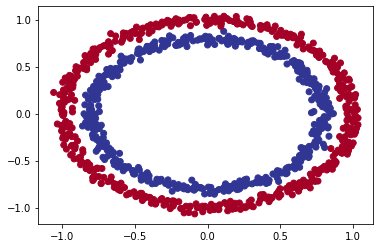

In [8]:
# visualize with the plot
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu");

Nice! From the plot, can you guess what kind of model we want to build ?

How about we try to build one to classify blue or red dots ? As in, a model which is able to distinguish blue from red dots.

> **Practice** : [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true)

## Input and Output Shapes

One of the most common issue you'll run into when building deep neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of output data.

In our case, we want to input `X` and get our model to predict `y`

So let's check out the shapes of `X` and `y`.

In [9]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

Where do these numbers come from ?

In [10]:
len(X), len(y)

(1000, 1000)

So we've got as many `X` values as we do `y` values, that makes sense.

In [12]:
# View the first example of features and labels
X[2], y[2]

(array([-0.81539193,  0.17328203]), 1)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.


> 🤔 **Note**: `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one of example of `y`(in our case, the output from our neural network has to be at least one value)



## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model**: piece together the layers of neural network yourself(using the functional or Sequential API) or import a previously built model(known as transfer learning).
2. **Compiling a model**: defining how a model's performance should be measured(loss/metrics) as well as defining how it should improve(optimizer).
3. **Fitting a model**: letting the model try to find patterns in the data(how does `X` get to `y`).

Let's see these in action using Sequential API to build a model for our regression data. And then we'll step through each.

In [14]:
# set the random seed
tf.random.set_seed(17)

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile a model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])

# 3. Fitting a model
model.fit(X, y, epochs = 100, verbose=0)

In [15]:
# 4. Evaluating a model
model.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931850910186768, 0.5]

Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [16]:
# Train our model for longer,
model.fit(X, y, epochs=200,verbose=0)
model.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5000


[0.6933965086936951, 0.5]

So even if we have trained our model for little longer than previous, it is not improving, it's performing like it's guessing.

What if we added an extra layer and trained for a little longer ?

In [18]:
# set random seed
tf.random.set_seed(17)

# 1. Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1), # add an extra layer
    tf.keras.layers.Dense(1)
])

# 2. Compile a model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])
# 3. Fit a model
model_1.fit(X, y, epochs=200, verbose=0)

# 4. Evaluate a model
model_1.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

So even we have added an extra layer the model is not improving.

Let's see what are things we have to do to improve our models.

## Improving a model

To improve a model, we can alter almost every part of the 3 steps we went thrugh before.

1. **Creating a model**: here we might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model**: you might want to choose a different optimization function (such as Adam optimizer, which is usually pretty good for any problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model**: we might train our model little longer by increasing the value of epochs.


How about first try adding more neurons, an extra layer and choose Adam as optimizer function?

In [19]:
# set the random seed
tf.random.set_seed(17)

# Create a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100), ## adding an extra layer with 100 neurons
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

# Compile a model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fitting a model
model_2.fit(X, y, epochs=200, verbose=0)

# Evaluating a model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4150


[0.6936585903167725, 0.41499999165534973]

Oh !

Accuracy decreases more.

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualization to see what's happening.

> 🔑 **Note**: Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **Visualize**, **Visualize**, **Visualize**. Inspect your data, inspect your model, inspect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features `X` and labels `y`.
* Create a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls)

If this sounds confusing, let's see it in code and then see the output.

In [20]:
import numpy as np

In [24]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function is adapated from two phenomenal resources:
  1. CS231n - https://cs231n.github.io/neural-networks-case-study/
  2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

  # Make predictions using trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # check the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multi-class classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classification...")
    y_pred = np.round(np.max(y_pred, axis = 1)).reshape(xx.shape)

  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

313/313 [==============================] - 0s 2ms/step
doing binary classification...


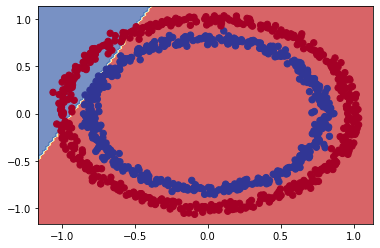

In [25]:
# check out the predictions our model is making
plot_decision_boundary(model_2, X, y)

Looks like our model is trying to draw a straight line through the data.

What's wrong with doing this ?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [27]:
# set random seed
tf.random.set_seed(17)

# create some regression data
X_regression = np.arange(0,1000,5)
y_regression = np.arange(100,1100,5)

# Split it into training and test sets
X_reg_train, y_reg_train = X_regression[:150], y_regression[:150]
X_reg_test, y_reg_test = X_regression[150:], y_regression[150:]

# Fit our model to the data
model_2.fit(tf.expand_dims(X_reg_train, axis = -1), y_reg_train, epochs = 100, verbose = 0)


ValueError: ignored

In [28]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               300       
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


We compiled our model for a binary classification problem.

We can recreate it for a regression problem.

In [29]:
# setup the random seed
tf.random.set_seed(17)

# Recreate a model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# compile a model, change the loss and metrics for regression model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# fit the model
model_3.fit(tf.expand_dims(X_reg_train, axis = -1), y_reg_train, epochs=100, verbose=0)

In [30]:
# evaluate the model
model_3.evaluate(X_reg_test, y_reg_test)

2/2 [==============================] - 0s 10ms/step - loss: 56.8959 - mae: 56.8959


[56.895851135253906, 56.895851135253906]

Let's plot the predictions

2/2 [==============================] - 0s 6ms/step


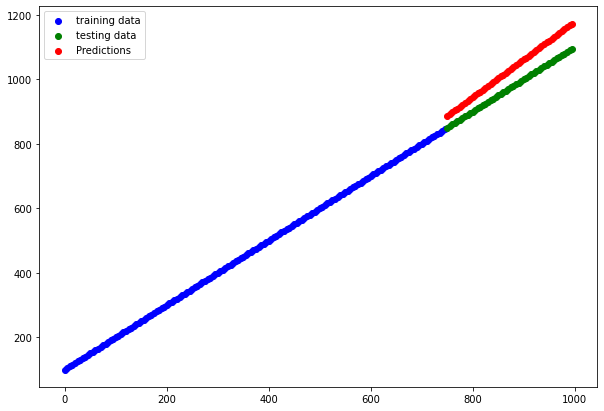

In [31]:
# Make a predictions with our trained model
y_reg_preds = model_3.predict(X_reg_test)

# plot the model's predictions against our regression data
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c='b', label='training data')
plt.scatter(X_reg_test, y_reg_test, c='g', label='testing data')
plt.scatter(X_reg_test, y_reg_preds.squeeze(), c='r', label='Predictions')
plt.legend();

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we are missing out on for our classification problem.